# Usage
Ideally the only thing that needs to be changed is: 
- The start/end date of the data
- The data ingestion portion

The rest should be taken care of, assuming no bugs

# Data parameters

In [1]:
# define bounding box
lat_bottom, lat_top = 33.9, 34.2
lon_bottom, lon_top = -118.4, -118.0
extent = (lon_bottom, lon_top, lat_bottom, lat_top)

# input data shape
dim = 200
frames_per_sample = 5

# date range of data - MODIFIED to use second week of December and January
dec_start_date, dec_end_date = "2024-12-16-00", "2024-12-23-00"
jan_start_date, jan_end_date = "2025-01-16-00", "2025-01-23-00"

# Data ingestion and preprocessing

In [2]:
# python nonsense that allows you to import from sibling directories
import sys
sys.path.append("..")

import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from dotenv import load_dotenv

# Import the data classes
from libs.pwwbdata import PWWBData
from libs.airnowdata import AirNowData
from libs.hrrrdata import HRRRData

# Load environment variables (API keys, credentials)
load_dotenv()

# split data
def train_test_split(X, train_size=0.75):
    split_idx = int(X.shape[0] * train_size)
    X_train, X_test = X[:split_idx], X[split_idx:]
    
    return X_train, X_test

# scale training data, then scale test data based on training data stats
from sklearn.preprocessing import StandardScaler
def std_scale(X_train, X_test):
    scaler = StandardScaler()
    scaled_train = scaler.fit_transform(X_train.reshape(-1, 1)).reshape(X_train.shape)
    scaled_test = scaler.transform(X_test.reshape(-1, 1)).reshape(X_test.shape)

    return scaled_train, scaled_test

In [3]:
# Create output directory for results
output_dir = "experiment_output"
os.makedirs(output_dir, exist_ok=True)
dec_end_date_adj = pd.to_datetime(dec_end_date) - pd.Timedelta(hours=1)
# ========== 1. Load December PWWB Data ==========
print("\nLoading December PWWB data...")
dec_pwwb = PWWBData(
    start_date=dec_start_date,
    end_date=dec_end_date,
    extent=extent,
    frames_per_sample=frames_per_sample,
    dim=dim,
    env_file='.env',
    verbose=True,
    output_dir=output_dir
)
X_dec_pwwb = dec_pwwb.data
channel_info = dec_pwwb.get_channel_info()
print(f"✓ December PWWB data shape: {X_dec_pwwb.shape}")
print(f"  Channels: {channel_info['channel_order']}")

# ========== 2. Load December AirNow Data ==========
print("\nLoading December AirNow data...")
dec_airnow = AirNowData(
    start_date=dec_start_date,
    end_date=dec_end_date_adj,
    extent=extent,
    airnow_api_key=os.getenv('AIRNOW_API_KEY'),
    frames_per_sample=frames_per_sample,
    dim=dim,
    elevation_path="../libs/inputs/elevation.npy",
    mask_path="../libs/inputs/mask.npy",
    force_reprocess=False
)
X_dec_airnow = dec_airnow.data
Y_dec = dec_airnow.target_stations
print(f"✓ December AirNow data shape: {X_dec_airnow.shape}")
if Y_dec is not None:
    print(f"  December target stations shape: {Y_dec.shape}")
else:
    print("  No December target stations available")

# ========== 3. Load December HRRR Data ==========
print("\nLoading December HRRR data...")
dec_hrrr = HRRRData(
    start_date=dec_start_date,
    end_date=dec_end_date_adj,
    extent=extent,
    extent_name='la_region',
    product='MASSDEN',
    frames_per_sample=frames_per_sample,
    dim=dim,
    verbose=True
)
# Convert units from kg to micrograms (1e9)
ug_per_kg = 1000000000
X_dec_hrrr = dec_hrrr.data * ug_per_kg
print(f"✓ December HRRR data shape: {X_dec_hrrr.shape}")


Loading December PWWB data...
Initialized PWWBData with 168 hourly timestamps
Date range: 2024-12-16 00:00:00 to 2024-12-22 23:00:00
Initialized PWWBData with 168 hourly timestamps
Date range: 2024-12-16 00:00:00 to 2024-12-22 23:00:00
Processing remote-sensing satellite imagery...
Fetching MAIAC AOD data for 7 unique dates
AOD data shape before resize: (5, 1200, 1200)
AOD data type: int16
AOD data min/max: -28672/537
Averaged AOD data to shape: (1200, 1200)
Resized AOD data to shape: (200, 200)
Successfully processed AOD data for 2024-12-16
AOD data shape before resize: (4, 1200, 1200)
AOD data type: int16
AOD data min/max: -28672/564
Averaged AOD data to shape: (1200, 1200)
Resized AOD data to shape: (200, 200)
Successfully processed AOD data for 2024-12-17
AOD data shape before resize: (4, 1200, 1200)
AOD data type: int16
AOD data min/max: -28672/554
Averaged AOD data to shape: (1200, 1200)
Resized AOD data to shape: (200, 200)
Successfully processed AOD data for 2024-12-18
AOD dat

QUEUEING TASKS | : 100%|██████████| 7/7 [00:00<00:00, 1148.90it/s]
PROCESSING TASKS | : 100%|██████████| 7/7 [00:28<00:00,  4.00s/it]
COLLECTING RESULTS | : 100%|██████████| 7/7 [00:00<00:00, 107153.75it/s]


Downloaded 7 MERRA-2 files to data/pwwb_cache/merra2_temp_2024_12
MERRA-2 dataset opened successfully
Available variables: ['BSTAR', 'CDH', 'CDM', 'CDQ', 'CN', 'DISPH', 'EFLUX', 'EVAP', 'FRCAN', 'FRCCN', 'FRCLS', 'FRSEAICE', 'GHTSKIN', 'HFLUX', 'HLML', 'NIRDF', 'NIRDR', 'PBLH', 'PGENTOT', 'PRECANV', 'PRECCON', 'PRECLSC', 'PRECSNO', 'PRECTOT', 'PRECTOTCORR', 'PREVTOT', 'QLML', 'QSH', 'QSTAR', 'RHOA', 'RISFC', 'SPEED', 'SPEEDMAX', 'TAUGWX', 'TAUGWY', 'TAUX', 'TAUY', 'TCZPBL', 'TLML', 'TSH', 'TSTAR', 'ULML', 'USTAR', 'VLML', 'Z0H', 'Z0M']
Dimensions: FrozenMappingWarningOnValuesAccess({'time': 168, 'lat': 361, 'lon': 576})
Coordinates: ['lon', 'lat', 'time']
Found geographic dimensions: lon=lon, lat=lat
Original size: 576 x 361
Subsetting to extent: -118.4 to -118.0, 33.9 to 34.2
Subset size: 1 x 1
Forced computation of dask arrays with .compute()
Native MERRA-2 resolution for this extent: 1 x 1 cells
Found variables: {'PBLH': 'PBLH', 'T2M': 'TLML', 'CDH': 'CDH'}
Stored native grid coordi

Ignoring index file '/home/moh/data/hrrr/20241216/la_region_subset_f9ef9dd4__hrrr.t00z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/moh/data/hrrr/20241216/la_region_subset_7fef9dd4__hrrr.t01z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/moh/data/hrrr/20241216/la_region_subset_73ef9dd4__hrrr.t02z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/moh/data/hrrr/20241216/la_region_subset_06ef9dd4__hrrr.t03z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/moh/data/hrrr/20241216/la_region_subset_feef9dd4__hrrr.t04z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/moh/data/hrrr/20241216/la_region_subset_f1ef9dd4__hrrr.t05z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/moh/data/hrrr/20241216/la_region_subset_c9ef9dd4__hrrr.t06z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/moh/data/hrrr/20241216/la_re

✓ December HRRR data shape: (164, 5, 200, 200, 1)


In [4]:
jan_end_date_adj = pd.to_datetime(jan_end_date) - pd.Timedelta(hours=1)
# ========== 4. Load January PWWB Data ==========
print("\nLoading January PWWB data...")
jan_pwwb = PWWBData(
    start_date=jan_start_date,
    end_date=jan_end_date,
    extent=extent,
    frames_per_sample=frames_per_sample,
    dim=dim,
    env_file='.env',
    verbose=True,
    output_dir=output_dir
)
X_jan_pwwb = jan_pwwb.data
print(f"✓ January PWWB data shape: {X_jan_pwwb.shape}")

# ========== 5. Load January AirNow Data ==========
print("\nLoading January AirNow data...")
jan_airnow = AirNowData(
    start_date=jan_start_date,
    end_date=jan_end_date_adj,
    extent=extent,
    airnow_api_key=os.getenv('AIRNOW_API_KEY'),
    frames_per_sample=frames_per_sample,
    dim=dim,
    elevation_path="../libs/inputs/elevation.npy",
    mask_path="../libs/inputs/mask.npy",
    force_reprocess=False
)
X_jan_airnow = jan_airnow.data
Y_jan = jan_airnow.target_stations
print(f"✓ January AirNow data shape: {X_jan_airnow.shape}")
if Y_jan is not None:
    print(f"  January target stations shape: {Y_jan.shape}")
else:
    print("  No January target stations available")

# ========== 6. Load January HRRR Data ==========
print("\nLoading January HRRR data...")
jan_hrrr = HRRRData(
    start_date=jan_start_date,
    end_date=jan_end_date_adj,
    extent=extent,
    extent_name='la_region',
    product='MASSDEN',
    frames_per_sample=frames_per_sample,
    dim=dim,
    verbose=True
)
# Convert units from kg to micrograms (1e9)
X_jan_hrrr = jan_hrrr.data * ug_per_kg
print(f"✓ January HRRR data shape: {X_jan_hrrr.shape}")


Loading January PWWB data...
Initialized PWWBData with 168 hourly timestamps
Date range: 2025-01-16 00:00:00 to 2025-01-22 23:00:00
Initialized PWWBData with 168 hourly timestamps
Date range: 2025-01-16 00:00:00 to 2025-01-22 23:00:00
Processing remote-sensing satellite imagery...
Loading cached MAIAC AOD data from data/pwwb_cache/maiac_aod_data.npy
Loading cached TROPOMI data from data/pwwb_cache/tropomi_data.npy
Processing wildfire/smoke data...
Loading cached MODIS fire data from data/pwwb_cache/modis_fire_data.npy
Loading cached MERRA-2 data from data/pwwb_cache/merra2_data.npy
Processing meteorological data...
Loading cached METAR data from data/pwwb_cache/metar_data.npy
Final data shape: (164, 5, 200, 200, 16)

Channel Statistics:

Channel 0: MAIAC_AOD
  Min: -28672.000000000007
  Max: -11405.030979015683
  Mean: -24606.076704338277
  Std: 4386.375562710705
  Data coverage: 100.00% (40000/40000 non-zero pixels)

Channel 1: TROPOMI_Methane
  Min: 1938.3544581494239
  Max: 1947.88

Exception has occured : HTTPSConnectionPool(host='noaa-hrrr-bdp-pds.s3.amazonaws.com', port=443): Max retries exceeded with url: /hrrr.20250120/conus/hrrr.t07z.wrfsfcf00.grib2.idx (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7f390c2bd2b0>: Failed to resolve 'noaa-hrrr-bdp-pds.s3.amazonaws.com' ([Errno -3] Temporary failure in name resolution)"))
Exception has occured : HTTPSConnectionPool(host='noaa-hrrr-bdp-pds.s3.amazonaws.com', port=443): Max retries exceeded with url: /hrrr.20250120/conus/hrrr.t08z.wrfsfcf00.grib2.idx (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7f390c494620>: Failed to resolve 'noaa-hrrr-bdp-pds.s3.amazonaws.com' ([Errno -3] Temporary failure in name resolution)"))
Exception has occured : HTTPSConnectionPool(host='noaa-hrrr-bdp-pds.s3.amazonaws.com', port=443): Max retries exceeded with url: /hrrr.20250120/conus/hrrr.t09z.wrfsfcf00.grib2.idx (Caused by NameResolutionError("<urllib3.connection.HT

▌▌Herbie HRRR model sfc product initialized 2025-Jan-16 00:00 UTC F00 ┊ source=aws
▌▌Herbie HRRR model sfc product initialized 2025-Jan-16 01:00 UTC F00 ┊ source=aws
▌▌Herbie HRRR model sfc product initialized 2025-Jan-16 02:00 UTC F00 ┊ source=aws
▌▌Herbie HRRR model sfc product initialized 2025-Jan-16 03:00 UTC F00 ┊ source=aws
▌▌Herbie HRRR model sfc product initialized 2025-Jan-16 04:00 UTC F00 ┊ source=aws
▌▌Herbie HRRR model sfc product initialized 2025-Jan-16 05:00 UTC F00 ┊ source=aws
▌▌Herbie HRRR model sfc product initialized 2025-Jan-16 06:00 UTC F00 ┊ source=aws
▌▌Herbie HRRR model sfc product initialized 2025-Jan-16 07:00 UTC F00 ┊ source=aws
▌▌Herbie HRRR model sfc product initialized 2025-Jan-16 08:00 UTC F00 ┊ source=aws
▌▌Herbie HRRR model sfc product initialized 2025-Jan-16 09:00 UTC F00 ┊ source=aws
▌▌Herbie HRRR model sfc product initialized 2025-Jan-16 10:00 UTC F00 ┊ source=aws
▌▌Herbie HRRR model sfc product initialized 2025-Jan-16 11:00 UTC F00 ┊ source=aws
▌▌He

Ignoring index file '/home/moh/data/hrrr/20250116/la_region_subset_45ef9dd4__hrrr.t00z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/moh/data/hrrr/20250116/la_region_subset_e3ef9dd4__hrrr.t01z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/moh/data/hrrr/20250116/la_region_subset_faef9dd4__hrrr.t02z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/moh/data/hrrr/20250116/la_region_subset_0eef9dd4__hrrr.t03z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/moh/data/hrrr/20250116/la_region_subset_bdef9dd4__hrrr.t04z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/moh/data/hrrr/20250116/la_region_subset_a8ef9dd4__hrrr.t05z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/moh/data/hrrr/20250116/la_region_subset_37ef9dd4__hrrr.t06z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/moh/data/hrrr/20250116/la_re

✓ January HRRR data shape: (164, 5, 200, 200, 1)


In [5]:
# ========== 7. Create the four experiment datasets ==========
print("\nCreating the four experiment datasets...")

# Experiment 1: No-fire December set (PWWB + AirNow)
print("  Experiment 1: No-fire December set (PWWB + AirNow)")
X_exp1 = np.concatenate([X_dec_pwwb, X_dec_airnow], axis=-1)
print(f"    Combined shape: {X_exp1.shape}")

# # Experiment 2: No-fire December set + HRRR
# print("  Experiment 2: No-fire December set + HRRR")
# X_exp2 = np.concatenate([X_dec_pwwb, X_dec_airnow, X_dec_hrrr], axis=-1)
# print(f"    Combined shape: {X_exp2.shape}")

# # Experiment 3: Fire January set (PWWB + AirNow)
# print("  Experiment 3: Fire January set (PWWB + AirNow)")
# X_exp3 = np.concatenate([X_jan_pwwb, X_jan_airnow], axis=-1)
# print(f"    Combined shape: {X_exp3.shape}")

# # Experiment 4: Fire January set + HRRR
# print("  Experiment 4: Fire January set + HRRR")
# X_exp4 = np.concatenate([X_jan_pwwb, X_jan_airnow, X_jan_hrrr], axis=-1)
# print(f"    Combined shape: {X_exp4.shape}")


Creating the four experiment datasets...
  Experiment 1: No-fire December set (PWWB + AirNow)
    Combined shape: (164, 5, 200, 200, 17)


In [6]:
# ========== 8. Train/Test Split for each experiment ==========
print("\nCreating train/test splits for each experiment...")

# Experiment 1 splits
X_exp1_train, X_exp1_test = train_test_split(X_exp1, train_size=0.75)
Y_dec_train, Y_dec_test = train_test_split(Y_dec, train_size=0.75)
print(f"  Experiment 1: Train={X_exp1_train.shape}, Test={X_exp1_test.shape}")

# # Experiment 2 splits
# X_exp2_train, X_exp2_test = train_test_split(X_exp2, train_size=0.75)
# print(f"  Experiment 2: Train={X_exp2_train.shape}, Test={X_exp2_test.shape}")

# # Experiment 3 splits
# X_exp3_train, X_exp3_test = train_test_split(X_exp3, train_size=0.75)
# Y_jan_train, Y_jan_test = train_test_split(Y_jan, train_size=0.75)
# print(f"  Experiment 3: Train={X_exp3_train.shape}, Test={X_exp3_test.shape}")

# # Experiment 4 splits
# X_exp4_train, X_exp4_test = train_test_split(X_exp4, train_size=0.75)
# print(f"  Experiment 4: Train={X_exp4_train.shape}, Test={X_exp4_test.shape}")

# ========== 9. Standardize data for each experiment ==========
print("\nStandardizing data for each experiment...")

# Experiment 1 standardization
X_exp1_train_scaled, X_exp1_test_scaled = std_scale(X_exp1_train, X_exp1_test)
print(f"  Experiment 1: Scaled train={X_exp1_train_scaled.shape}, test={X_exp1_test_scaled.shape}")

# # Experiment 2 standardization
# X_exp2_train_scaled, X_exp2_test_scaled = std_scale(X_exp2_train, X_exp2_test)
# print(f"  Experiment 2: Scaled train={X_exp2_train_scaled.shape}, test={X_exp2_test_scaled.shape}")

# # Experiment 3 standardization
# X_exp3_train_scaled, X_exp3_test_scaled = std_scale(X_exp3_train, X_exp3_test)
# print(f"  Experiment 3: Scaled train={X_exp3_train_scaled.shape}, test={X_exp3_test_scaled.shape}")

# # Experiment 4 standardization
# X_exp4_train_scaled, X_exp4_test_scaled = std_scale(X_exp4_train, X_exp4_test)
# print(f"  Experiment 4: Scaled train={X_exp4_train_scaled.shape}, test={X_exp4_test_scaled.shape}")


Creating train/test splits for each experiment...
  Experiment 1: Train=(123, 5, 200, 200, 17), Test=(41, 5, 200, 200, 17)

Standardizing data for each experiment...
  Experiment 1: Scaled train=(123, 5, 200, 200, 17), test=(41, 5, 200, 200, 17)


In [7]:
# ========== 10. Save prepared datasets ==========
print("\nSaving prepared datasets...")

# Create directories for each experiment
exp_dirs = {}
for i in range(1, 5):
    exp_dir = os.path.join(output_dir, f"experiment{i}")
    os.makedirs(exp_dir, exist_ok=True)
    exp_dirs[i] = exp_dir

# Save Experiment 1 data
np.save(os.path.join(exp_dirs[1], "X_train.npy"), X_exp1_train_scaled)
np.save(os.path.join(exp_dirs[1], "X_test.npy"), X_exp1_test_scaled)
np.save(os.path.join(exp_dirs[1], "y_train.npy"), Y_dec_train)
np.save(os.path.join(exp_dirs[1], "y_test.npy"), Y_dec_test)

# # Save Experiment 2 data
# np.save(os.path.join(exp_dirs[2], "X_train.npy"), X_exp2_train_scaled)
# np.save(os.path.join(exp_dirs[2], "X_test.npy"), X_exp2_test_scaled)
# np.save(os.path.join(exp_dirs[2], "y_train.npy"), Y_dec_train)
# np.save(os.path.join(exp_dirs[2], "y_test.npy"), Y_dec_test)

# # Save Experiment 3 data
# np.save(os.path.join(exp_dirs[3], "X_train.npy"), X_exp3_train_scaled)
# np.save(os.path.join(exp_dirs[3], "X_test.npy"), X_exp3_test_scaled)
# np.save(os.path.join(exp_dirs[3], "y_train.npy"), Y_jan_train)
# np.save(os.path.join(exp_dirs[3], "y_test.npy"), Y_jan_test)

# # Save Experiment 4 data
# np.save(os.path.join(exp_dirs[4], "X_train.npy"), X_exp4_train_scaled)
# np.save(os.path.join(exp_dirs[4], "X_test.npy"), X_exp4_test_scaled)
# np.save(os.path.join(exp_dirs[4], "y_train.npy"), Y_jan_train)
# np.save(os.path.join(exp_dirs[4], "y_test.npy"), Y_jan_test)

print("\n✓ All datasets prepared and saved!")
print("Ready to run experiments 1-4")


Saving prepared datasets...

✓ All datasets prepared and saved!
Ready to run experiments 1-4


# Data visualization

Visualizing data from all experiments...


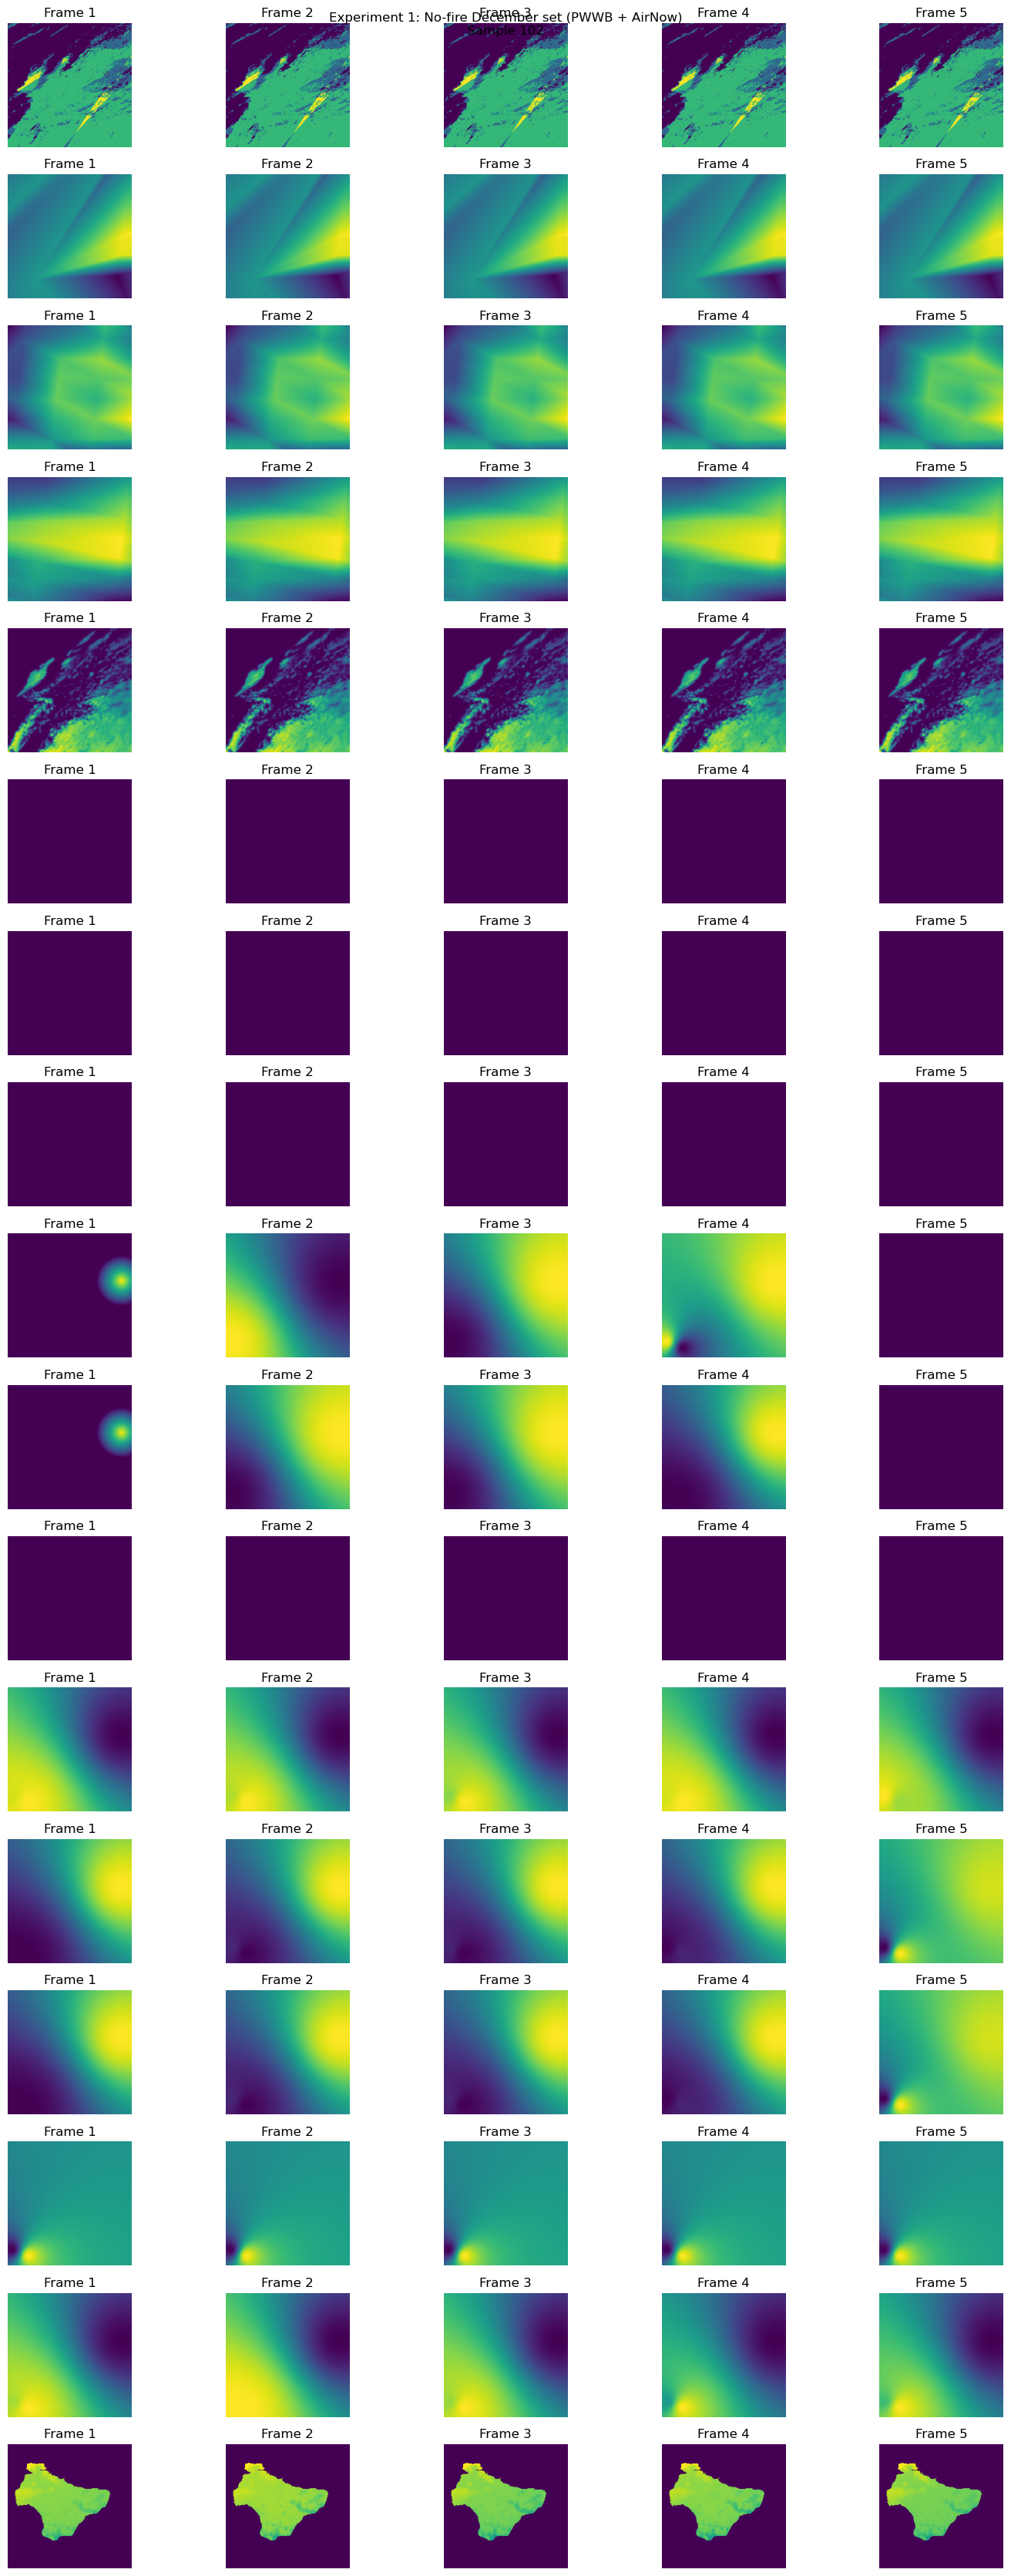

Target values: [26.6 23.5 10.2]


In [8]:
# Function to visualize data from any experiment
def visualize_experiment_data(X, y, exp_number, sample_idx=None):
    """Visualize data from a specific experiment"""
    # Get a random sample if none provided
    if sample_idx is None:
        np.random.seed(42)
        sample_idx = np.random.choice(range(len(X)), size=1)[0]
    
    # Get channel information
    n_channels = X.shape[4]
    n_frames = X.shape[1]
    
    # Create figure
    fig, axes = plt.subplots(n_channels, n_frames, figsize=(3*n_frames, 2*n_channels))
    if n_channels == 1:
        axes = axes.reshape(1, -1)
    
    # Plot each channel and frame
    for c in range(n_channels):
        for f in range(n_frames):
            ax = axes[c, f]
            ax.imshow(X[sample_idx, f, :, :, c])
            if f == 0:
                ax.set_ylabel(f"Channel {c}")
            ax.set_title(f"Frame {f+1}")
            ax.axis("off")
    
    # Set title
    exp_descriptions = {
        1: "No-fire December set (PWWB + AirNow)",
        # 2: "No-fire December set + HRRR",
        # 3: "Fire January set (PWWB + AirNow)",
        # 4: "Fire January set + HRRR"
    }
    plt.suptitle(f"Experiment {exp_number}: {exp_descriptions[exp_number]}\nSample {sample_idx}")
    plt.tight_layout()
    plt.show()
    
    # Print target values
    print(f"Target values: {y[sample_idx]}")

# Visualize a sample from each experiment
print("Visualizing data from all experiments...")
visualize_experiment_data(X_exp1_train_scaled, Y_dec_train, 1)
# visualize_experiment_data(X_exp2_train_scaled, Y_dec_train, 2)
# visualize_experiment_data(X_exp3_train_scaled, Y_jan_train, 3)
# visualize_experiment_data(X_exp4_train_scaled, Y_jan_train, 4)

# Model

In [9]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Conv3D
from keras.layers import ConvLSTM2D
from keras.layers import BatchNormalization
from keras.layers import Convolution2D, MaxPooling3D, Flatten, Reshape
from keras.layers import TimeDistributed
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import InputLayer

tf.keras.backend.set_image_data_format('channels_last')

# Function to run a single experiment
def run_experiment(exp_number, epochs=150, batch_size=4):
    """Train and evaluate a model for a specific experiment"""
    # Set up experiment data
    if exp_number == 1:
        X_train = X_exp1_train_scaled
        y_train = Y_dec_train
        X_test = X_exp1_test_scaled
        y_test = Y_dec_test
        description = "No-fire December set (PWWB + AirNow)"
    # elif exp_number == 2:
    #     X_train = X_exp2_train_scaled
    #     y_train = Y_dec_train
    #     X_test = X_exp2_test_scaled
    #     y_test = Y_dec_test
    #     description = "No-fire December set + HRRR"
    # elif exp_number == 3:
    #     X_train = X_exp3_train_scaled
    #     y_train = Y_jan_train
    #     X_test = X_exp3_test_scaled
    #     y_test = Y_jan_test
    #     description = "Fire January set (PWWB + AirNow)"
    # elif exp_number == 4:
    #     X_train = X_exp4_train_scaled
    #     y_train = Y_jan_train
    #     X_test = X_exp4_test_scaled
    #     y_test = Y_jan_test
    #     description = "Fire January set + HRRR"
    else:
        print(f"Invalid experiment number: {exp_number}")
        return None
    
    print(f"\n==== Running Experiment {exp_number}: {description} ====")
    print(f"Training data shape: {X_train.shape}")
    print(f"Target data shape: {y_train.shape}")
    
    # Build model
    seq = Sequential()
    
    seq.add(
        InputLayer(shape=X_train.shape[1:])
    )
    
    seq.add(
        ConvLSTM2D(
                filters=15, 
                kernel_size=(3, 3),
                padding='same', 
                return_sequences=True
        )
    )
    
    seq.add(
        ConvLSTM2D(
            filters=30, 
            kernel_size=(3, 3),
            padding='same', 
            return_sequences=True
        )
    )
    
    seq.add(
        Conv3D(
            filters=15, 
            kernel_size=(3, 3, 3),
            activation='relu',
            padding='same'    
        )
    )
    
    seq.add(
        Conv3D(
            filters=1, 
            kernel_size=(3, 3, 3),
            activation='relu',
            padding='same'
        )
    )
    
    seq.add(Flatten())
    seq.add(Dense(y_train.shape[1], activation='relu'))
    
    # Compile model
    seq.compile(loss='mean_absolute_error', optimizer='adam')
    
    # Print model summary
    seq.summary()
    
    # Train model
    print(f"\nTraining model for experiment {exp_number}...")
    history = seq.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_split=0.2
    )
    
    # Evaluate model
    print(f"\nEvaluating model for experiment {exp_number}...")
    test_loss = seq.evaluate(X_test, y_test, verbose=0)
    print(f"Test MAE: {test_loss:.4f}")
    
    # Make predictions
    y_pred = seq.predict(X_test, verbose=0)
    
    # Calculate metrics
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"Root Mean Squared Error: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")
    
    # Plot training history
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.legend()
    plt.title(f'Experiment {exp_number}: {description}\nTraining Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MAE)')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Save results
    results_dir = os.path.join(output_dir, f"experiment{exp_number}", "results")
    os.makedirs(results_dir, exist_ok=True)
    
    np.save(os.path.join(results_dir, "y_pred.npy"), y_pred)
    seq.save(os.path.join(results_dir, "model.h5"))
    
    return {
        'model': seq,
        'history': history,
        'loss': test_loss,
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'y_pred': y_pred,
        'y_test': y_test
    }

2025-05-19 18:23:00.045782: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-19 18:23:00.354400: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-19 18:23:01.862006: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.



==== Running Experiment 1: No-fire December set (PWWB + AirNow) ====
Training data shape: (123, 5, 200, 200, 17)
Target data shape: (123, 3)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 5, 200, 200,    │        17,340 │
│                                 │ 15)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 5, 200, 200,    │        48,720 │
│                                 │ 30)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 5, 200, 200,    │        12,165 │
│                                 │ 15)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 5, 200, 200, 1) │           406 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 200000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │       600,003 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 678,634 (2.59 MB)

 Trainable params: 678,634 (2.59 MB)

 Non-trainable params: 0 (0.00 B)


Training model for experiment 1...
Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 490ms/step - loss: 17.4724 - val_loss: 25.5867
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 438ms/step - loss: 14.9757 - val_loss: 23.8471
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 435ms/step - loss: 13.8645 - val_loss: 24.0346
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 439ms/step - loss: 12.3631 - val_loss: 21.6760
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 438ms/step - loss: 11.2197 - val_loss: 21.4709
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 434ms/step - loss: 11.5220 - val_loss: 22.8364
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 439ms/step - loss: 12.0063 - val_loss: 20.8067
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 435ms/step - loss: 11.7041 - val_loss: 21.2638
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 441ms/step - loss: 11.3011 - val_loss: 20.7242
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 445ms/step - loss: 11.3553 - val_loss: 21.9546
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 441ms/step - loss: 11.8304 - v

2025-05-19 18:32:01.157647: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 435200000 bytes after encountering the first element of size 435200000 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Mean Absolute Error: 23.3665
Root Mean Squared Error: 25.5131
R² Score: -6.5100


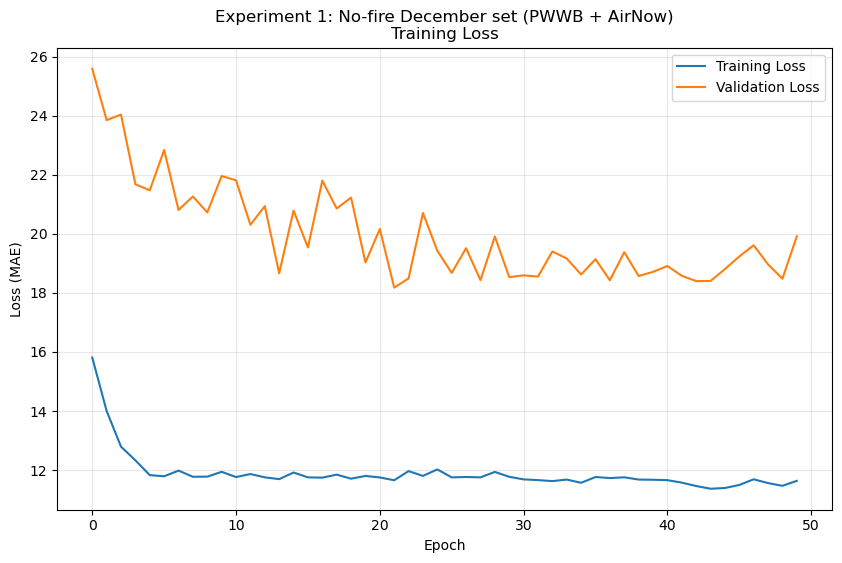

In [10]:
# Run Experiment 1: No-fire December set (PWWB + AirNow)
exp1_results = run_experiment(1, epochs=50)  # Reduced epochs for faster testing

In [11]:
# Run Experiment 2: No-fire December set + HRRR
# exp2_results = run_experiment(2, epochs=50)

In [12]:
# Run Experiment 3: Fire January set (PWWB + AirNow)
# exp3_results = run_experiment(3, epochs=50)

In [13]:
# Run Experiment 4: Fire January set + HRRR
# exp4_results = run_experiment(4, epochs=50)

# Evaluate


==== Experiment Comparison ====
Experiment 1 (No-fire December): MAE = 23.3665


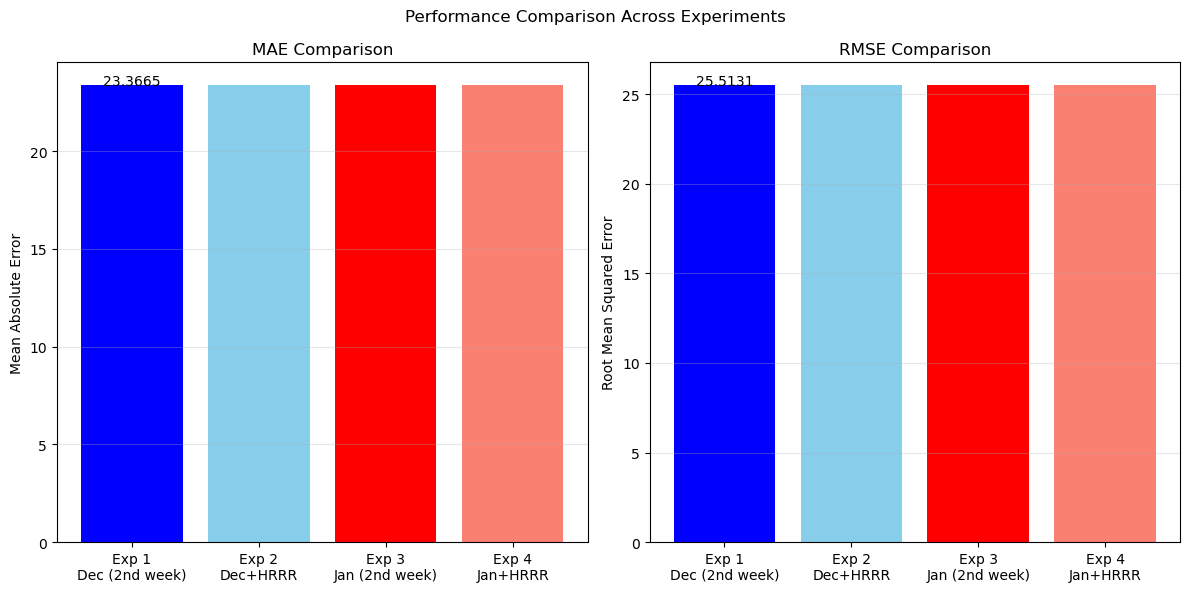


Experiment comparison complete!


In [14]:
# Compare results across all experiments
print("\n==== Experiment Comparison ====")
print(f"Experiment 1 (No-fire December): MAE = {exp1_results['mae']:.4f}")
# print(f"Experiment 2 (No-fire December + HRRR): MAE = {exp2_results['mae']:.4f}")
# print(f"Experiment 3 (Fire January): MAE = {exp3_results['mae']:.4f}")
# print(f"Experiment 4 (Fire January + HRRR): MAE = {exp4_results['mae']:.4f}")

# Visualize comparison
experiments = ['Exp 1\nDec (2nd week)', 'Exp 2\nDec+HRRR', 'Exp 3\nJan (2nd week)', 'Exp 4\nJan+HRRR']
# , exp2_results['mae'], exp3_results['mae'], exp4_results['mae']
maes = [exp1_results['mae']]
# ,exp2_results['rmse'], exp3_results['rmse'], exp4_results['rmse']
rmses = [exp1_results['rmse']]

plt.figure(figsize=(12, 6))

# Plot MAEs
plt.subplot(1, 2, 1)
plt.bar(experiments, maes, color=['blue', 'skyblue', 'red', 'salmon'])
plt.title('MAE Comparison')
plt.ylabel('Mean Absolute Error')
plt.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(maes):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center')

# Plot RMSEs
plt.subplot(1, 2, 2)
plt.bar(experiments, rmses, color=['blue', 'skyblue', 'red', 'salmon'])
plt.title('RMSE Comparison')
plt.ylabel('Root Mean Squared Error')
plt.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(rmses):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center')

plt.suptitle('Performance Comparison Across Experiments')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'experiment_comparison.png'))
plt.show()

# Save comparison results
with open(os.path.join(output_dir, 'experiment_comparison.txt'), 'w') as f:
    f.write("==== Experiment Comparison ====\n")
    f.write(f"Experiment 1 (No-fire December, 2nd week): MAE = {exp1_results['mae']:.4f}, RMSE = {exp1_results['rmse']:.4f}, R² = {exp1_results['r2']:.4f}\n")
    # f.write(f"Experiment 2 (No-fire December + HRRR, 2nd week): MAE = {exp2_results['mae']:.4f}, RMSE = {exp2_results['rmse']:.4f}, R² = {exp2_results['r2']:.4f}\n")
    # f.write(f"Experiment 3 (Fire January, 2nd week): MAE = {exp3_results['mae']:.4f}, RMSE = {exp3_results['rmse']:.4f}, R² = {exp3_results['r2']:.4f}\n")
    # f.write(f"Experiment 4 (Fire January + HRRR, 2nd week): MAE = {exp4_results['mae']:.4f}, RMSE = {exp4_results['rmse']:.4f}, R² = {exp4_results['r2']:.4f}\n")
    f.write(f"\nAnalysis completed on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

print("\nExperiment comparison complete!")

In [15]:
# For detailed analysis of a specific experiment (e.g., Experiment 1)
# Choose which experiment to analyze
selected_exp = 1  # Change this to analyze a different experiment (1-4)

# Set the appropriate data and results
if selected_exp == 1:
    X_test = X_exp1_test_scaled
    y_test = Y_dec_test
    y_pred = exp1_results['y_pred']
    model = exp1_results['model']
    description = "No-fire December set (PWWB + AirNow), 2nd week"
# elif selected_exp == 2:
#     X_test = X_exp2_test_scaled
#     y_test = Y_dec_test
#     y_pred = exp2_results['y_pred']
#     model = exp2_results['model']
#     description = "No-fire December set + HRRR, 2nd week"
# elif selected_exp == 3:
#     X_test = X_exp3_test_scaled
#     y_test = Y_jan_test
#     y_pred = exp3_results['y_pred']
#     model = exp3_results['model']
#     description = "Fire January set (PWWB + AirNow), 2nd week"
# elif selected_exp == 4:
#     X_test = X_exp4_test_scaled
#     y_test = Y_jan_test
#     y_pred = exp4_results['y_pred']
#     model = exp4_results['model']
#     description = "Fire January set + HRRR, 2nd week"
else:
    print(f"Invalid experiment number: {selected_exp}")

print(f"Analyzing Experiment {selected_exp}: {description}")

Analyzing Experiment 1: No-fire December set (PWWB + AirNow), 2nd week



Detailed analysis for Experiment 1:

1. Plotting prediction comparison...


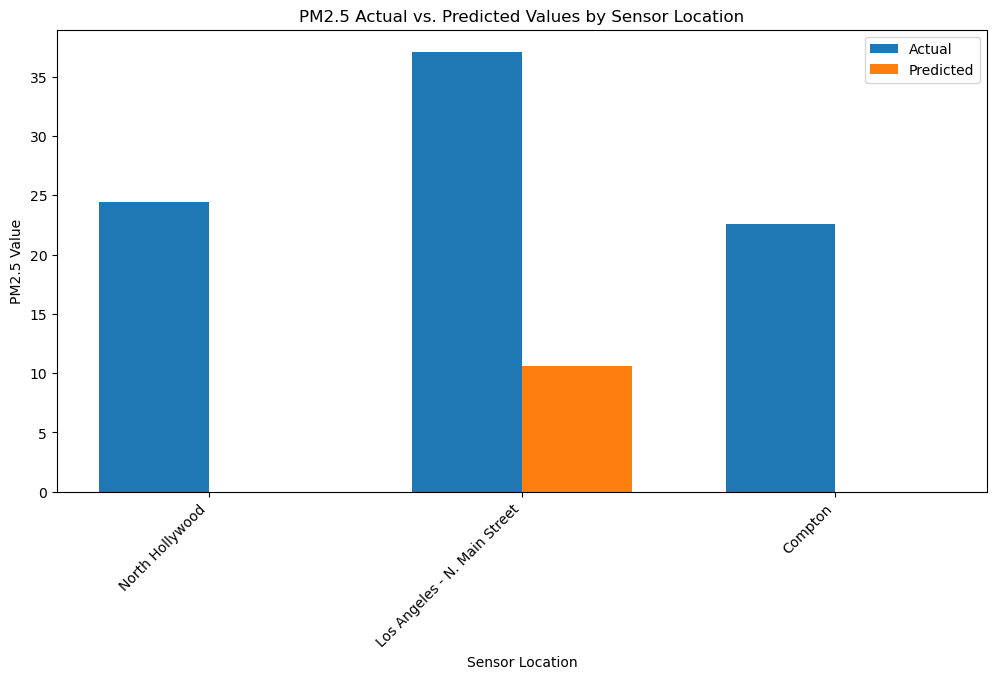


2. Plotting scatter comparison...


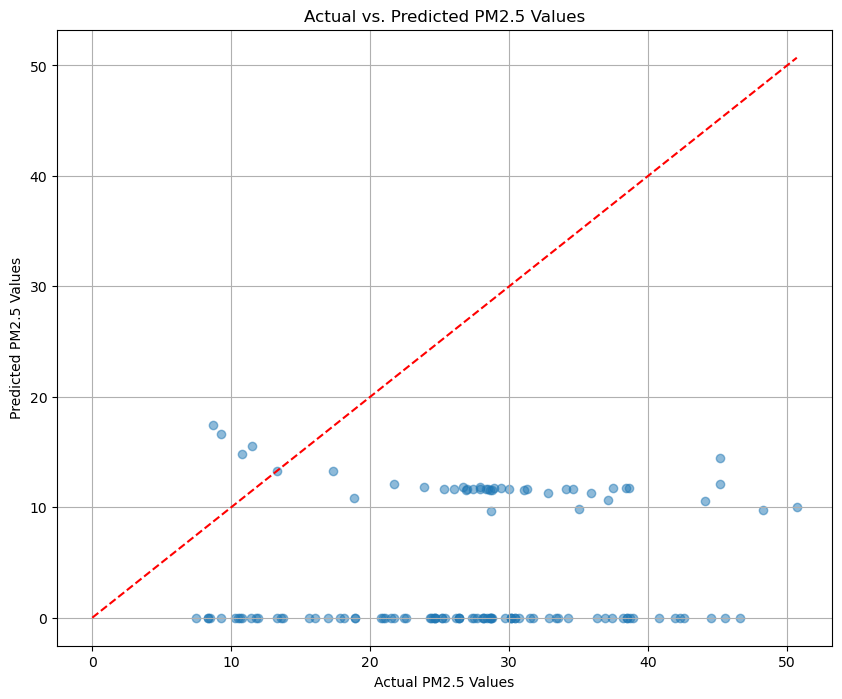


3. Plotting error by sensor...


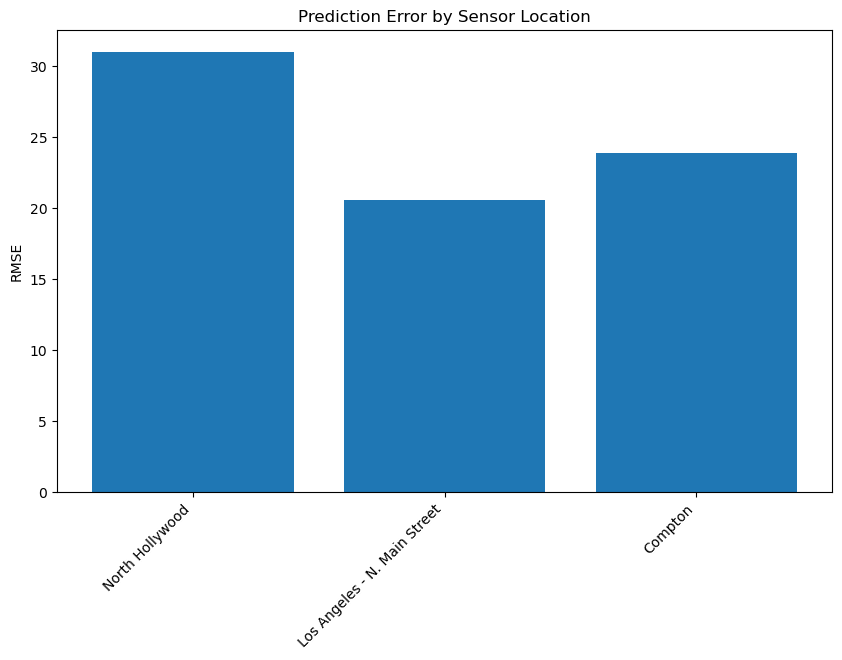


4. Plotting time series comparison...


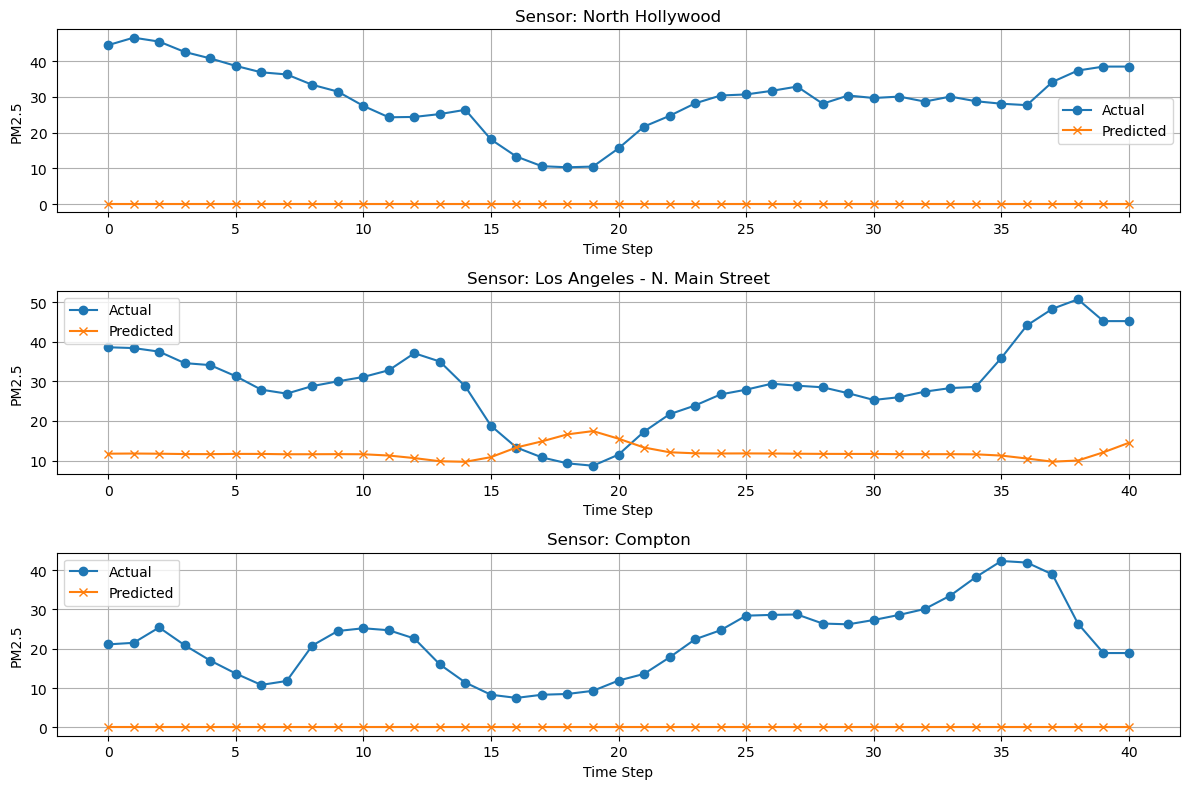


5. Plotting time series with shifted predictions...


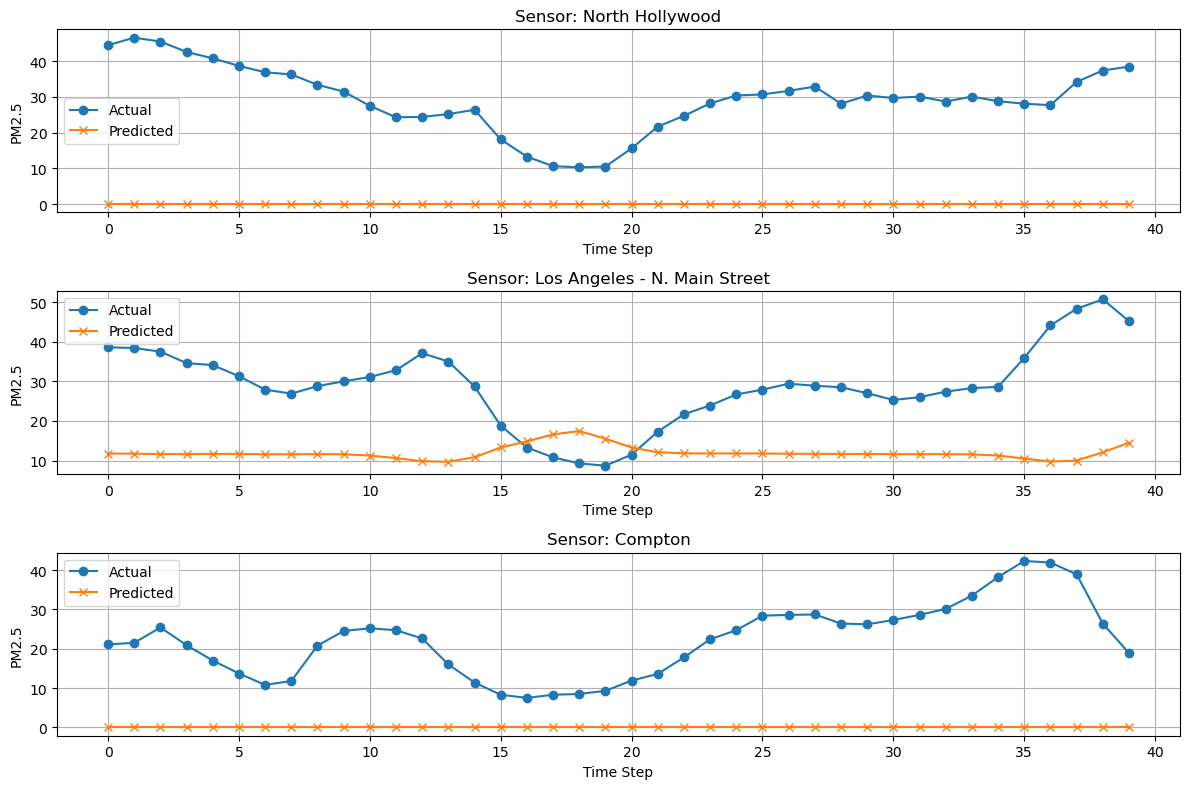


6. Printing metrics...
RESULTS
---------------------------------------------------------------------------
All Days All Locations - y_pred vs y_test Raw RMSE: 25.51
All Days All Locations - y_pred vs y_test RMSE Percent Error of Mean: 94.58%

RESULTS BY FRAME
---------------------------------------------------------------------------
Frame 1 (Hour 1) All Locations - Raw RMSE: 32.39
Frame 1 (Hour 1) All Locations - RMSE Percent Error of Mean: 93.25%

Frame 2 (Hour 2) All Locations - Raw RMSE: 33.38
Frame 2 (Hour 2) All Locations - RMSE Percent Error of Mean: 94.02%

Frame 3 (Hour 3) All Locations - Raw RMSE: 33.56
Frame 3 (Hour 3) All Locations - RMSE Percent Error of Mean: 92.88%

Frame 4 (Hour 4) All Locations - Raw RMSE: 30.43
Frame 4 (Hour 4) All Locations - RMSE Percent Error of Mean: 93.06%

Frame 5 (Hour 5) All Locations - Raw RMSE: 28.63
Frame 5 (Hour 5) All Locations - RMSE Percent Error of Mean: 93.45%

Frame 6 (Hour 6) All Locations - Raw RMSE: 26.27
Frame 6 (Hour 6) All Loc

In [16]:
from libs.plotting import (
    plot_prediction_comparison,
    plot_scatter_comparison,
    plot_error_by_sensor,
    plot_time_series_comparison,
    plot_input_frames,
    print_metrics
)

# Sensor names (use AirNow sensor names if available)
if hasattr(dec_airnow, 'sensor_names') and dec_airnow.sensor_names is not None:
    sensor_names = dec_airnow.sensor_names
else:
    sensor_names = ["North Hollywood", "Los Angeles - N. Main Street", "Compton"]

print(f"\nDetailed analysis for Experiment {selected_exp}:")
print("\n1. Plotting prediction comparison...")
plot_prediction_comparison(y_pred, y_test, sensor_names, sample_idx=12)

print("\n2. Plotting scatter comparison...")
plot_scatter_comparison(y_pred, y_test)

print("\n3. Plotting error by sensor...")
plot_error_by_sensor(y_pred, y_test, sensor_names)

print("\n4. Plotting time series comparison...")
plot_time_series_comparison(y_pred, y_test, sensor_names)
    
print("\n5. Plotting time series with shifted predictions...")
plot_time_series_comparison(y_pred, y_test, sensor_names, shift_pred=1)

print("\n6. Printing metrics...")
print_metrics(y_pred, y_test, sensor_names)